In [1]:
from typing import Any
import numpy as np
import torch
import torchvision

In [2]:
# Chargement des données
train = torchvision.datasets.MNIST('mnist_dataset', train=True, download=True,
                             transform=torchvision.transforms.ToTensor())
test = torchvision.datasets.MNIST('mnist_dataset', train=False, download=True,
                             transform=torchvision.transforms.ToTensor())

In [3]:
print(f"Shape of the data {train.data.size()}, the first dimension is the number of examples")
print(f"Shape of the targets {train.targets.size()}")

Shape of the data torch.Size([60000, 28, 28]), the first dimension is the number of examples
Shape of the targets torch.Size([60000])


In [4]:
# TODO commenter chacune des dimensions (dites à quoi elles correspondent)
# 60 000 individus (images) de 28 x 28 pixel et en niveaux de gris 0 - 255

In [5]:
# Pour faciliter la création de batch on utiliser une classe appelé DataLoader
# Pour les données d'entrainements on mélange les données à chaque époque pour avoir des batchs différents d'une époque à l'autre
train_loader = torch.utils.data.DataLoader(train, batch_size=100, shuffle=True)
test_loader = torch.utils.data.DataLoader(test, batch_size=500, shuffle=False)

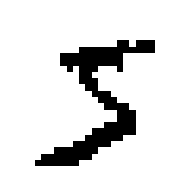

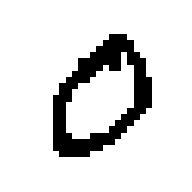

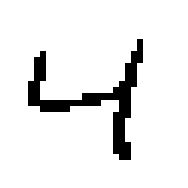

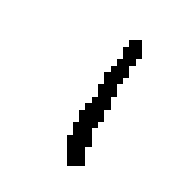

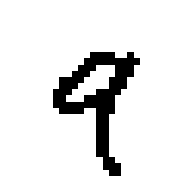

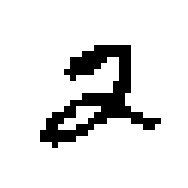

In [6]:
import matplotlib.pyplot as plt

# Cette cellule sert à afficher six images du jeux d'entrainenment
fig = plt.figure()
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.tight_layout()
    # Définissez les couleurs pour 0 (blanc) et 1 (noir)
    colors = ['white', 'black']
    # Affichez l'image avec imshow
    plt.imshow(train.data[i], cmap=plt.matplotlib.colors.ListedColormap(colors))
    # l'image sans axes
    plt.axis('off')
    # Affichez l'image
    plt.show()

In [10]:
import torch.nn as nn

# Définition de la classe du modèle
class NeuralNetwork(nn.Module):

    def __init__(self):
        super(NeuralNetwork, self).__init__()
        #TODO initialiser les éléments nécessaire pour le modèle

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)

        self.couche1 = nn.Linear(64 * 7 * 7, 128)

        self.sortie = nn.Linear(128, 10)

        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        # TODO appliquer le modèle sur x
        y = self.pool(self.relu(self.conv1(x)))
        y = self.pool(self.relu(self.conv2(y)))

        y = torch.flatten(y, start_dim=1)

        y = self.relu(self.couche1(y))
        y = self.softmax(self.sortie(y))
        return y

In [11]:
# Création d'une instance du modèle
model = NeuralNetwork()

# On affiche les paramètres du modèle
for name, param in model.named_parameters():
    if param.requires_grad:
        print("Nom du paramètres : ",name, "   taille du tenseur : ", param.data.size())
pytorch_total_params = sum(p.numel() for p in model.parameters())
print(f"Le nombre total de paramètre à entrainer dans le modèle est de {pytorch_total_params}")

Nom du paramètres :  conv1.weight    taille du tenseur :  torch.Size([32, 1, 3, 3])
Nom du paramètres :  conv1.bias    taille du tenseur :  torch.Size([32])
Nom du paramètres :  conv2.weight    taille du tenseur :  torch.Size([64, 32, 3, 3])
Nom du paramètres :  conv2.bias    taille du tenseur :  torch.Size([64])
Nom du paramètres :  couche1.weight    taille du tenseur :  torch.Size([128, 3136])
Nom du paramètres :  couche1.bias    taille du tenseur :  torch.Size([128])
Nom du paramètres :  sortie.weight    taille du tenseur :  torch.Size([10, 128])
Nom du paramètres :  sortie.bias    taille du tenseur :  torch.Size([10])
Le nombre total de paramètre à entrainer dans le modèle est de 421642


In [12]:
# appliquer le modèle sur un batch pour vérifier qu'il accepte l'input et vérifier l'output
for data, _ in train_loader:
  print("Dimension de l'input : ", data.size())
  print("Dimension de l'output : ", model(data).size())
  break

Dimension de l'input :  torch.Size([100, 1, 28, 28])
Dimension de l'output :  torch.Size([100, 10])


In [13]:
import torch.optim as optim

# TODO Instanciation de la fonction de perte (entropie croisée)
fonction_perte = nn.CrossEntropyLoss()

# TODO Instanciation de l'optimiseur (par exemple, Adam)
optimizer = optim.Adam(model.parameters())



In [14]:
# Boucle d'entraînement
num_epochs = 10
train_losses = [] # Pour chaque époque, on stocke la perte sur le jeu d'entrainement pour voir l'évolution de la perte au fil des époques
test_losses = [] # Pour chaque époque, on stocke la perte sur le jeu de test pour comparer les performances du modèle entre le jeu d'apprentissage et celui de test

for epoch in range(num_epochs):
    total_loss = 0.0
    model.train()

    # DataLoader est un iterable, c'est à dire qu'on peut le parcourir, chaque itération retourne les données d'input et la target du batch
    for data, target in train_loader:
        # TODO entrainer le modèle
        optimizer.zero_grad() 
        out = model(data)
        loss = fonction_perte(out,target)
        loss.backward()
        optimizer.step()

        # On stocke la perte de l'époque en cours pour le jeu d'entrainement
        total_loss += loss.item()

    # Calculer et stocker la perte moyenne pour cette époque => sert pour afficher la courbe d'apprentissage
    average_loss = total_loss / len(train_loader)
    train_losses.append(average_loss)
    print(f"Total mean lost on train {average_loss}")

    # Mettre le modèle en mode "évaluation", pour éviter qu'il effectue des opérations d'entrainement
    # On calcule la perte sur le testset pour comparer les scores entre le trainset et le testset
    model.eval()
    test_loss = 0.0
    with torch.no_grad(): # le modèle ne va pas calculer les gradient
        for inputs, labels in test_loader:  # Boucler sur les batch du jeux de test
            # TODO utiliser le modèle sur les données de test
            outputs = model(inputs)
            # On stocke la perte de l'époque en cours pour le jeu d'évaluation
            test_loss += fonction_perte(outputs, labels).item()
    test_losses.append(test_loss / len(test_loader))

print('Entraînement terminé.')

Total mean lost on train 1.6124434024095535
Total mean lost on train 1.4872426402568817
Total mean lost on train 1.4799763892094295
Total mean lost on train 1.4760096716880797
Total mean lost on train 1.4738426226377488
Total mean lost on train 1.472378093202909
Total mean lost on train 1.4714587744077046
Total mean lost on train 1.4701743624607722
Total mean lost on train 1.4695473704735438
Total mean lost on train 1.4690795314311982
Entraînement terminé.


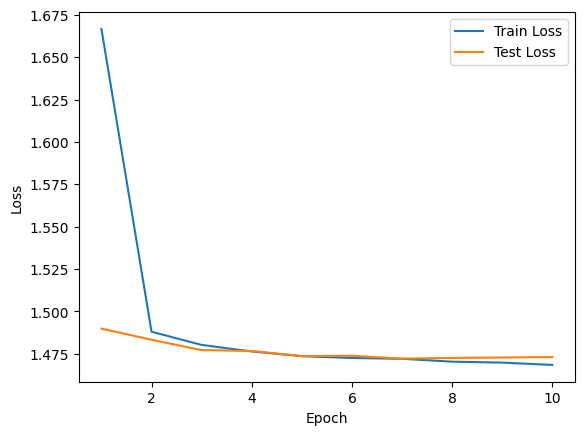

In [13]:
# Tracez les courbes de perte
plt.plot(np.arange(1, num_epochs +1), train_losses, label='Train Loss')
plt.plot(np.arange(1, num_epochs + 1), test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [14]:
# TODO expliquer pourquoi on affiche les deux courbes de la perte moyenne de chaque époque
# car chaque époques, on itere les données pas batch

# TODO commenter les courbes ci-dessus ? Et expliquer pourquoi il y a grand écart à la première époque entre le testset et le trainset ?
# la loss du test est calculée après avoir mis à jour les poids lors de la première époque

# TODO que pensez vous de la proposition suivante : on devrait entrainer le modèle sur deux fois plus d'époque ?
# inutile -> oervefiting car la courbe s'est déja stabilisée

In [28]:
# On va évaluer notre modèle à l'aide de métrique.
from re import X
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
# On met le modèle en mode évaluation
model.eval()


# TODO calculer l'accuracy à l'aide de la fonction accuracy_score  de sklearn, stocker les prédictions sur le jeux d'évaluation dans une variable nommée predictions
predictions_list = []
targets_list = []

# Mettre le modèle en mode évaluation
model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        # images: (batch_size, 1, 28, 28), labels: (batch_size,)
        images = images.to(torch.float32)
        outputs = model(images)  # Supposons que outputs a la forme (batch_size, 10)
        _, preds = torch.max(outputs, 1)  # On sélectionne la classe avec la probabilité la plus élevée
        predictions_list.append(preds.cpu())
        targets_list.append(labels.cpu())

# Concaténer les prédictions et les cibles sur tous les batchs
predictions = torch.cat(predictions_list)
targets = torch.cat(targets_list)


accuracy = accuracy_score(targets, predictions)
print(accuracy)


0.9891


In [ ]:
# TODO expliquer en une phrase ce que le chiffre de l'accuracy représente
# Le taux de bonnes prédictions

tensor([2, 3, 4, 5, 6, 2, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 1, 0, 1, 2, 7, 5,
        3, 4, 4, 0, 0, 6, 9, 6, 6, 5, 7, 2, 3, 4, 4, 9, 1, 4, 0, 7, 9, 5, 7, 2,
        3, 1, 4, 4, 0, 9, 9, 6, 1, 8, 3, 3, 7, 3, 9, 8, 8, 4, 7, 7, 6, 2, 1, 9,
        8, 7, 8, 8, 7, 2, 2, 3, 9, 3, 3, 5, 5, 0, 7, 9, 5, 6, 5, 1, 4, 1, 1, 2,
        8, 2, 6, 1, 5, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8,
        9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 8, 0, 6, 0, 2, 2, 3, 7, 7, 4, 7, 1, 7, 1,
        7, 1, 4, 0, 0, 1, 7, 5, 7, 1, 3, 3, 3, 1, 6, 9, 7, 1, 3, 0, 2, 6, 0, 8,
        9, 7, 3, 5, 4, 8, 1, 5, 9, 0, 6, 2, 3, 8, 1, 4, 7, 5, 2, 0, 0, 1, 7, 8,
        9, 6, 8, 8, 2, 3, 6, 1, 2, 9, 5, 2, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1,
        2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 6, 6, 7, 8, 9, 7, 4, 6, 1, 4, 0,
        9, 9, 3, 7, 8, 4, 7, 5, 8, 5, 3, 2, 2, 0, 5, 8, 6, 0, 3, 8, 1, 0, 3, 0,
        4, 7, 4, 9, 2, 9, 0, 7, 1, 7, 1, 6, 6, 5, 6, 2, 8, 7, 6, 4, 9, 9, 5, 3,
        7, 4, 3, 0, 9, 6, 6, 1, 1, 3, 2,

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       980
           1       1.00      1.00      1.00      1135
           2       0.97      1.00      0.99      1032
           3       0.99      0.99      0.99      1010
           4       1.00      0.98      0.99       982
           5       0.99      0.99      0.99       892
           6       0.99      0.99      0.99       958
           7       0.99      0.99      0.99      1028
           8       1.00      0.97      0.99       974
           9       0.97      0.99      0.98      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



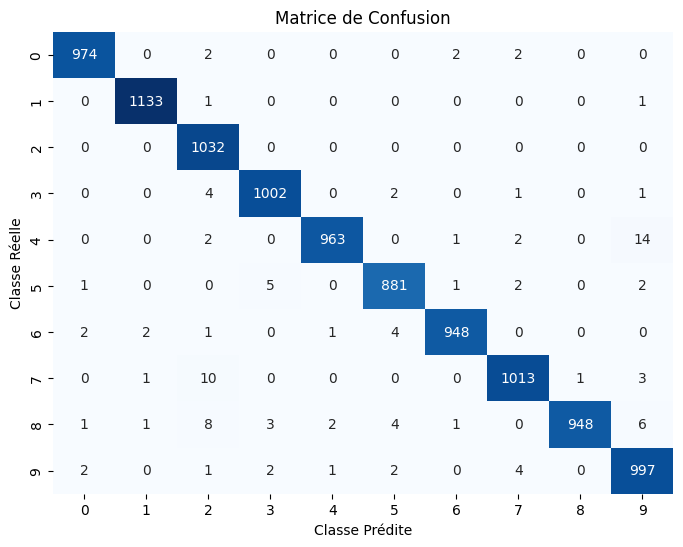

In [27]:
# On calcule des métriques et on affiche la matrice de confusion
report = classification_report(targets, predictions, target_names=["0","1","2","3","4","5", "6","7", "8", "9"])
print(report)

# Confusion matrice
confusion = confusion_matrix(targets, predictions)

import seaborn as sns
import matplotlib.pyplot as plt
# Créez une figure
plt.figure(figsize=(8, 6))

# Utilisez seaborn pour afficher la matrice de confusion avec des couleurs
sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues", cbar=False)

# Ajoutez des labels aux axes
plt.xlabel("Classe Prédite")
plt.ylabel("Classe Réelle")
plt.title("Matrice de Confusion")

# Affichez la figure
plt.show()

In [ ]:
# TODO commenter le report
# le modele est assez précis avec une accuracy de 99%
# TODO Quel chiffre le modèle confond le plus souhaite avec quel autre chiffre ?
# il confnd les 7 pouvant ressembler des 2 et les 4 puvant ressembler à des 9
# TODO Comment peut-on calculer la précision du modèle à partir de ce graphique ?
# pour avoir l'accuracy sur ce modèle, il faut la somme des True Positifs divisées par les nombre d'individus (somme de toutes les cases)

In [31]:
# on charge les nouvelles données
from google.colab import files
uploaded = files.upload()

# Si vous travaillez en local vous pouvez charger le fichier avec  nouveaux_chiffres_tenseur = torch.load(file_path) auquel inutile d'appliquer la cellule ci dessous

ModuleNotFoundError: No module named 'google.colab'

In [ ]:
# Accédez au contenu du fichier
for file_name, data in uploaded.items():
    with open(file_name, 'wb') as f:
        f.write(data)

# Chargez le tenseur à partir du fichier
nouveaux_chiffres_tenseur = torch.load(file_name)


In [ ]:
print(f"taille du tenseur des nouvelles données : {nouveaux_chiffres_tenseur.size()}")

In [ ]:
model.eval()
# On utilise le modèle pour prédire la classe des nouvelles données
with torch.no_grad(): # le modèle ne va pas calculer les gradient
    y_pred = model(nouveaux_chiffres_tenseur)

In [ ]:
# Afficher les tensors et leur prédiction
for prediction, chiffre in zip(y_pred, nouveaux_chiffres_tenseur):
    plt.figure()
    # Définissez les couleurs pour 0 (blanc) et 1 (noir)
    colors = ['white', 'black']

    # Affichez l'image avec imshow
    plt.imshow(chiffre, cmap=plt.matplotlib.colors.ListedColormap(colors))
    plt.axis('off')
    print(f'La prédiction de limage ci-dessous est {torch.argmax(prediction)}')
    plt.show()


In [ ]:
# Les deux dernières images sont des images de validation issu du dataset initial, leur prédiction devrait être juste.
# TODO pourquoi le modèle se trompe sur les autres chiffres ?
# surement car les dimensions sont differentes